In [2]:
import pandas as pd
import numpy as np


In [3]:
#Reading Data
train = pd.read_csv("MusicRatingsTrain.csv")
test = pd.read_csv("MusicRatingsTest.csv")
valA = pd.read_csv("MusicRatingsValidationA.csv")
valB = pd.read_csv("MusicRatingsValidationB.csv")

#Sorting Data
train = train.sort_values(by = ['userID', 'songID'])
test = test.sort_values(by = ['userID', 'songID'])
valA = valA.sort_values(by = ['userID', 'songID'])
valB = valB.sort_values(by = ['userID', 'songID'])
train

,userID,songID,rating,songName,year,artist,genre
116572,1,10,1.784426,Harder Better Faster Stronger,2007,Daft Punk,Electronic
63286,1,22,1.000000,Up Up & Away,2009,Kid Cudi,Rap
219232,1,26,3.451920,Undo,2001,Bjork,Rock
243057,1,34,1.000000,Nah!,2002,Shania Twain,Country
103269,1,35,1.784426,Imma Be,2009,Black Eyed Peas,Rap
...,...,...,...,...,...,...,...
4444,2421,778,1.494918,Take What You Take,2006,Lily Allen,Pop
153176,2421,783,1.000000,Just Friends,2006,Amy Winehouse,RnB
223448,2421,787,1.784426,Ragoo,2007,Kings Of Leon,Rock
163979,2421,791,1.000000,One,1988,Metallica,Rock


In [4]:
#Summary Statisics of Training Data
num_songs = len(set(train['songID']))
num_users = len(set(train['userID']))
print("There are", num_users, "users and",num_songs, "songs in the training set.")
print('Summary Statistics for Rating variable:')
train['rating'].describe()

There are 2421 users and 807 songs in the training set.
Summary Statistics for Rating variable:


count    245997.000000
mean          1.321962
std           0.459894
min           1.000000
25%           1.000000
50%           1.000000
75%           1.494918
max           4.768656
Name: rating, dtype: float64

In [5]:
from fancyimpute import BiScaler
from fancyimpute import SoftImpute

$\Large Simple Additive Model:$
$\Large {X_i,_j} = {\alpha_i} + {\beta_j} + {\epsilon_i,_j }$


In [6]:
print('There are ' + str(num_songs+num_users) + ' parameters to fit in the simple additive model.')

There are 3228 parameters to fit in the simple additive model.


In [7]:
#Converting DataFrames to Matricies

#Fills in Matrix with ratings of songs for each user
train_df = train.pivot_table(index = 'userID', columns = 'songID', values = 'rating', dropna = False)
train_mat = train_df.to_numpy()
train_mask = ~np.isnan(train_mat)


#Account for the fact that some users are not in the test or val dataset 
user_df = train_df.reset_index()[['userID']]

test_df = test.pivot_table(index = 'userID', columns = 'songID', values = 'rating', dropna = False)
test_df = pd.merge(user_df,test_df.reset_index(),how='outer',on='userID')
test_df = test_df.set_index('userID')
test_mat = test_df.to_numpy()
test_mask = ~np.isnan(test_mat)

valA_df = valA.pivot_table(index = 'userID', columns = 'songID', values = 'rating', dropna = False)
valA_df = pd.merge(user_df,valA_df.reset_index(),how='outer',on='userID')
valA_df = valA_df.set_index('userID')
valA_mat = valA_df.to_numpy()
valA_mask = ~np.isnan(valA_mat)

valB_df = valB.pivot_table(index = 'userID', columns = 'songID', values = 'rating', dropna = False)
valB_df = pd.merge(user_df,valB_df.reset_index(),how='outer',on='userID')
valB_df = valB_df.set_index('userID')
valB_mat = valB_df.to_numpy()
valB_mask = ~np.isnan(valB_mat)


#BiScaler to fit the Simple Additive Model
music_biscaler = BiScaler(scale_rows=False, scale_columns=False, verbose=True)
train_mat_centered = music_biscaler.fit_transform(train_mat)

[BiScaler] Initial log residual value = 8.635876
[BiScaler] Iter 1: log residual = -1.278081, log improvement ratio=9.913958
[BiScaler] Iter 2: log residual = -2.464318, log improvement ratio=1.186237
[BiScaler] Iter 3: log residual = -3.599288, log improvement ratio=1.134970
[BiScaler] Iter 4: log residual = -4.728969, log improvement ratio=1.129681
[BiScaler] Iter 5: log residual = -5.851105, log improvement ratio=1.122136
[BiScaler] Iter 6: log residual = -6.961307, log improvement ratio=1.110202
[BiScaler] Iter 7: log residual = -8.052791, log improvement ratio=1.091484
[BiScaler] Iter 8: log residual = -9.115833, log improvement ratio=1.063043
[BiScaler] Iter 9: log residual = -10.137984, log improvement ratio=1.022150
[BiScaler] Iter 10: log residual = -11.105953, log improvement ratio=0.967969
[BiScaler] Iter 11: log residual = -12.009465, log improvement ratio=0.903512
[BiScaler] Iter 12: log residual = -12.845445, log improvement ratio=0.835981
[BiScaler] Iter 13: log residual

In [8]:
#Analysis Tables
alpha = {'alpha': music_biscaler.row_means}
beta = {'beta': music_biscaler.column_means}

#alpha represents affinity for user i to rate songs highly
user_alpha = pd.DataFrame(data = alpha, index = np.arange(1,2422))
user_alpha

#beta represents quality of song j
song_beta = pd.DataFrame(data = beta, index = np.arange(1,808))
song_beta.sort_values(by='beta', ascending = False )

,beta
54,2.157841
26,2.137063
439,2.038437
637,1.937541
600,1.889610
...,...
317,1.073712
157,1.073472
165,1.072993
96,1.071808


In [9]:
#Three most popular songs after removing bias due to user's affinity ro rate songs highly
song_1 = train[train['songID']==54].iloc[[0]]
song_2 = train[train['songID']==26].iloc[[0]]
song_3 = train[train['songID']==439].iloc[[0]]

song_1

,userID,songID,rating,songName,year,artist,genre
164100,1,54,3.45192,You're The One,1990,Dwight Yoakam,Country


In [10]:
song_2

,userID,songID,rating,songName,year,artist,genre
219232,1,26,3.45192,Undo,2001,Bjork,Rock


In [11]:
song_3

,userID,songID,rating,songName,year,artist,genre
164963,1,439,2.774262,Secrets,2009,OneRepublic,Rock


In [12]:
#Three users that are the most enthused about songs after removing for song's popularity
print('The ids of the users most enthused about songs are 1540,838, and 1569')
user_alpha.sort_values(by='alpha', ascending=False)

The ids of the users most enthused about songs are 1540,838, and 1569


,alpha
1540,0.967014
838,0.814727
1569,0.794237
950,0.691602
345,0.674504
...,...
2076,-0.404973
1550,-0.405059
1595,-0.408122
241,-0.409727


In [13]:
#Out-of-Sample Performance of Fitted Model on Test Set

#Performance functions
def masked_mae(X_true, X_pred, mask):
    masked_diff = X_true[mask] - X_pred[mask]
    return np.mean(np.abs(masked_diff))

def masked_mse(X_true, X_pred, mask):
    masked_diff = X_true[mask] - X_pred[mask]
    return np.mean(masked_diff ** 2)


#Estimations 
import copy
train_centered_0 = copy.copy(train_mat_centered)
train_centered_0[np.isnan(train_centered_0)]=0
train_filled = music_biscaler.inverse_transform(train_centered_0)

biscale_test_mae = masked_mae(test_mat, train_filled, test_mask)
biscale_test_mse = masked_mse(test_mat, train_filled, test_mask)

print("Biscale MAE %s " % (biscale_test_mae/4))
print("Biscale RMSE %s " % ((biscale_test_mse)**.5/4))


Biscale MAE 0.07475717751330167 
Biscale RMSE 0.0985693901114982 


$\Large Collaborative Filtering Model:$
$\Large {X_i,_j} = {Z_i,_j} +{\alpha_i} + {\beta_j} + {\epsilon_i,_j }$
where Z is a matrix with a rank of at most k


In [14]:
print('There are 3328k +' + str(num_songs+num_users) + ' parameters to fit in the Collaborative Filtering model.')

There are 3328k +3228 parameters to fit in the Collaborative Filtering model.


In [15]:
#SoftImpute to fit a Collaborative Filtering Model

#Determine the value of K, the number of archeatypes using Cross-Validation and ValA
valA_mae_lst = []
for i in range(20):
    param_cv = i+1
    soft_imputer_cv = SoftImpute(max_rank=param_cv, verbose=False)
    centered_filled_cv = soft_imputer_cv.fit_transform(train_mat_centered)
    filled_cv = music_biscaler.inverse_transform(centered_filled_cv)
    filled_cv = np.clip(filled_cv, 1, 5)
    valA_mae_cv = masked_mae(valA_mat, filled_cv, valA_mask)
    valA_mae_lst.append(valA_mae_cv)
    print('iter %s - Validation MAE %s' % (param_cv,valA_mae_cv))


iter 1 - Validation MAE 0.28855099032346393
iter 2 - Validation MAE 0.2856178541408906
iter 3 - Validation MAE 0.28278185799367006
iter 4 - Validation MAE 0.2829164922015336
iter 5 - Validation MAE 0.2830230690387448
iter 6 - Validation MAE 0.28387258691969536
iter 7 - Validation MAE 0.28404455676441026
iter 8 - Validation MAE 0.283852921363869
iter 9 - Validation MAE 0.286558349914518
iter 10 - Validation MAE 0.28683195469642614
iter 11 - Validation MAE 0.28773033028970985
iter 12 - Validation MAE 0.2914933214766025
iter 13 - Validation MAE 0.2909473804420015
iter 14 - Validation MAE 0.2933785220157129
iter 15 - Validation MAE 0.2914308477910588
iter 16 - Validation MAE 0.2925178453413245
iter 17 - Validation MAE 0.2956043644793459
iter 18 - Validation MAE 0.2983149426795692
iter 19 - Validation MAE 0.3012189962332117
iter 20 - Validation MAE 0.3010951886526976


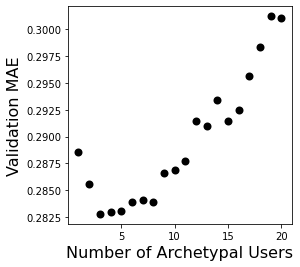

In [17]:
import matplotlib.pyplot as plt
x = range(1,21)
y = valA_mae_lst
plt.figure(figsize=(4, 4))
plt.scatter(x, y, linewidth=2, color='black')
plt.xlabel('Number of Archetypal Users', fontsize=16)
plt.ylabel('Validation MAE', fontsize=16)
plt.show()

In [18]:
print('The MAE is minimized when k=4.')

The MAE is minimized when k=4.


In [22]:
#SoftImpute to build Collaborative Filtering Model

soft_imputer = SoftImpute(max_rank=4, verbose=True) 
SI = soft_imputer.fit_transform(train_mat_centered)
filled_matrix = music_biscaler.inverse_transform(SI)
filled_matrix = np.clip(filled_matrix, 1, 5)

[SoftImpute] Max Singular Value of X_init = 35.403703
[SoftImpute] Iter 1: observed MAE=0.278323 rank=4
[SoftImpute] Iter 2: observed MAE=0.274806 rank=4
[SoftImpute] Iter 3: observed MAE=0.272477 rank=4
[SoftImpute] Iter 4: observed MAE=0.270856 rank=4
[SoftImpute] Iter 5: observed MAE=0.269595 rank=4
[SoftImpute] Iter 6: observed MAE=0.268651 rank=4
[SoftImpute] Iter 7: observed MAE=0.267855 rank=4
[SoftImpute] Iter 8: observed MAE=0.267189 rank=4
[SoftImpute] Iter 9: observed MAE=0.266614 rank=4
[SoftImpute] Iter 10: observed MAE=0.266110 rank=4
[SoftImpute] Iter 11: observed MAE=0.265664 rank=4
[SoftImpute] Iter 12: observed MAE=0.265258 rank=4
[SoftImpute] Iter 13: observed MAE=0.264894 rank=4
[SoftImpute] Iter 14: observed MAE=0.264561 rank=4
[SoftImpute] Iter 15: observed MAE=0.264268 rank=4
[SoftImpute] Iter 16: observed MAE=0.264005 rank=4
[SoftImpute] Iter 17: observed MAE=0.263776 rank=4
[SoftImpute] Iter 18: observed MAE=0.263565 rank=4
[SoftImpute] Iter 19: observed MAE=0.

In [23]:
#Collaborative Filtering Model Performance
biscale_test_mae = masked_mae(test_mat, filled_matrix, test_mask)
biscale_test_mse = masked_mse(test_mat, filled_matrix, test_mask)
print("Collaborative Filtering MAE %s " % (biscale_test_mae/4))
print("Collaborative Filtering RMSE %s " % ((biscale_test_mse)**.5/4))


Collaborative Filtering MAE 0.07104179409190274 
Collaborative Filtering RMSE 0.09630976396852671 


$\Large Additional Models$

$\large Linear Regression$

In [24]:
#Linear Regression only using genre and year song was released 
import statsmodels.formula.api as smf
train['genre'] = train['genre'].astype('category')
train['year'] =train.year.astype('category') 
test['genre'] = test['genre'].astype('category')
test['year'] =test.year.astype('category') 
valA['genre'] = valA['genre'].astype('category')
valA['year'] =valA.year.astype('category') 
valB['genre'] = valB['genre'].astype('category')
valB['year'] =valB.year.astype('category')
 
linear_model = smf.ols(formula = 'rating ~ year + genre', data = train).fit()
print(linear_model.summary()) 



                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     261.6
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:59:28   Log-Likelihood:            -1.5373e+05
No. Observations:              245997   AIC:                         3.075e+05
Df Residuals:                  245963   BIC:                         3.079e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.0937    

In [204]:
ols_mae = np.mean(np.abs(test['rating'] - linear_model.predict(test[['year','genre']])))/4
ols_rmse = np.mean((test['rating'] - linear_model.predict(test[['year','genre']]))**2)**.5/4
ols_r2 = 1-(np.sum((test['rating'] - linear_model.predict(test[['year','genre']]))**2))/np.sum((test['rating'] - np.mean(test['rating']))**2)
print("OLS MAE %s " % ols_mae)
print("OLS RMSE %s " % ols_rmse)
print("OLS OSR2 %s " % ols_r2)


OLS MAE 0.092355681535926 
OLS RMSE 0.11312545968408197 
OLS OSR2 0.03878977350390367 


$\large Random Forest$

In [119]:
from sklearn.ensemble import RandomForestRegressor

X_train = train.drop(columns=['userID','songID', 'rating', 'songName','artist'])
X_train = pd.get_dummies(X_train, columns =['year', 'genre'])
Y_train = train['rating']
X_test = test.drop(columns=['userID','songID', 'rating', 'songName','artist'])
X_test = pd.get_dummies(X_test, columns =['year', 'genre'])
Y_test = test['rating']

rf = RandomForestRegressor(max_features = 5, min_samples_leaf = 5, n_estimators = 500, random_state = 88 , verbose= 2)
rf.fit(X_train, Y_train )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.3min finished


RandomForestRegressor(max_features=5, min_samples_leaf=5, n_estimators=500,
                      random_state=88, verbose=2)

In [205]:
rf_mae = np.mean(np.abs(test['rating'] - rf.predict(X_test)))/4
rf_rmse = np.mean((test['rating'] - rf.predict(X_test))**2)**.5/4
rf_r2 = 1-(np.sum((test['rating'] - rf.predict(X_test))**2))/np.sum((test['rating'] - np.mean(test['rating']))**2)
print("Random Forest MAE %s " % rf_mae)
print("Random Forest RMSE %s " % rf_rmse)
print("Random Forest OSR2 %s " % rf_r2)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Random Forest MAE 0.0915266668751549 
Random Forest RMSE 0.1124341282649891 
Random Forest OSR2 0.050502156249242924 


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished
